# comp_TideConv_tpxo
compute barotropic to baroclinic tide conversion using [St. Laurent & Garrett 2002], adapted from C. Vic code.

### This code:
* regional scale: grid is regular and cartesioen (approximately)
* stratification is horizontally homogeneous
* tides are taken from TPXO8 or forcing file of ROMS computation
* topography, longitude and latitude are retrieved from ROMS grid file

### Limitations:
Originally, [St. Laurent & Garrett 2002] is relevant for "weak" topography and no important variations of tide and bathymetry. Here, we implicetely assume that tidal constituents are "frozen" at every points. Besides, finite-depth effect are taken into account by using a finite lower bound of integration in the spectral space (roughly corresponding to mode 1), which is taken constant here (whereas variations of kh_1 scales like 1/H)


In [35]:
%matplotlib inline
import matplotlib     

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.usetex'] = False
import scipy.interpolate as interp
import scipy.signal as sig
import scipy.stats as stats
from netCDF4 import Dataset
#from SW_Density import SW_Density as rhop # temporary
from comp_rho import rhop
from distance_sphere_matproof import dist_sphere_matproof
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from change_coord import reproject_image_into_polar
#from mpi4py import MPI 
from pad_coords import pad_coords   # for padding fields outside of domain
from detrend_2d import detrend_2d
clock  = datetime.now()
#comm = MPI.COMM_WORLD
import time

doverb = True


In [2]:
# --- MPI parameters --- 
npx,npy = 16,16 # number of processors in x and y directions  
#npx,npy = 1,1 # number of processors in x and y directions  

#rank = comm.Get_rank()
#size = comm.Get_size()
rank, size = 0, 1
if size!=npx*npy:
    print('mpi size is {0} vs. {1}x{2}'.format(size,npx,npy))
    #raise ValueError('number of subdomains different from number of procs -> failure!')

# --- data location ---
path_data = '/data0/project/vortex/lahaye/Tide_Conv/input_data/' # './input_data/' #
path_data = '/net/krypton'+path_data     # if not on LOPS hub (or libra)

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky"

# --- tide dataset --- 
tide = 'tpxo8'
if tide == 'lucky':
    collot = True    # tides and topo defined on same points
    uname = path_data+'luckym2_frc.nc' # see read_write_TPXO8_netcdf.py
elif tide == 'tpxo8':
    collot = False
    uname = path_data+'TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc'
    hname = path_data+'TPXO8/grid_tpxo8_atlas_30c_v1.nc'
    
# --- global grid ---   
colloc = True    # use same grid as topo // False not implemented
if colloc:
    nstep = 10
else:
    dspace = 1e3       # resolution of the final map in meter
#lonmin_g,lonmax_g = -33,-32     # test box // None takes the whole domain defined by h  
#latmin_g,latmax_g = 37,37.7  
lonmin_g, latmin_g, lonmax_g, latmax_g = [None]*4  # entire domain

# --- output location and name --- 
path_write = path_data.replace('input','output')
file_write = 'Ef_{0}_{1}_mpi.{2:02d}.nc'.format(topo,tide,rank)   

# --- miscellaneous --- 
if topo == "lucky":
    file_topo = path_data+"lucky_grd.nc"
    Lchk = 150e3    # length of window for computing topo spectrum
    varx, vary = 'lon_rho', 'lat_rho'    # variable names in netCDF files
    varh = 'h'

zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
omega      = 7.2921e-5         # Earth's rotation rate [rad s-1]
M2         = 2.*np.pi/(44700.) # M2 tide frequency [rad s-1] 
lonm,latm  = -32.16,37.17      # Momar mooring location 
Erad = 6371e3                  # Earth radius [m]

### warning: make sure the following lines are in agreement with subsequent parameters and grids
nxout = 256    # number of points for k modulus
nxoth = 128    # number of points for k angle
khout = np.linspace(1./Lchk,1./750/np.sqrt(2.),nxout)*np.pi  # k adim for output = k*bar(N)*H/sqrt(M2^2-f^2)
thout = np.linspace(0,np.pi*2,nxoth+1)[:-1]  # theta for output

mpi size is 1 vs. 16x16


In [3]:
# ------ get mean topo on the grid, will be used to get N2b --------
# load the entire grid (regional modelling purpose)
nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure
if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    if lonmin_g is None:
        ix = [0]
    else:
        ix = [np.abs(lon_h-lonmin_g).argmin(axis=0).min()]
    if lonmax_g is None:
        ix.append(nlon_h)
    else:
        ix.append(np.abs(lon_h-lonmax_g).argmin(axis=0).max())
    if latmin_g is None:
        jy = [0]
    else:
        jy = [np.abs(lat_h-latmin_g).argmin(axis=1).min()]
    if latmax_g is None:
        jy.append(nlat_h)
    else:
        jy.append(np.abs(lat_h-latmax_g).argmin(axis=1).max())
    h_t = -nc.variables[varh][jy[0]:jy[1],ix[0]:ix[1]].T
    h_t[h_t>=-2.5]     = 0     # land points  
    #lon = lon[ix[0]:ix[1],jy[0]:jy[1]]
    #lat = lat[ix[0]:ix[1],jy[0]:jy[1]]
    #Nxh, Nyh = lon_g.shape
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
nc.close()

In [4]:
# --- grids (coordinates relative to proc number) ---
# working with (x,y)-ordered grids
if colloc:
    lon2d_g = lon_h[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep]
    lat2d_g = lat_h[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep]
    nlon_g, nlat_g = lon2d_g.shape
else:
    lon1d_g       = np.arange(lonmin_g,lonmax_g+dspace,dspace) 
    lat1d_g       = np.arange(latmin_g,latmax_g+dspace,dspace) 
    nlat_g,nlon_g = lat1d_g.shape[0],lon1d_g.shape[0] 
di            = nlon_g//npx
dj            = nlat_g//npy
if di*npx<nlon_g: di+=1 # correction to make sure all the area is covered
if dj*npy<nlat_g: dj+=1
imin          = di*(rank%npx)
jmin          = dj*(rank//npx)
imax          = imin+di
jmax          = jmin+dj

# --- define subgrids ---
if colloc:
    lon2d, lat2d = lon2d_g[imin:imax,jmin:jmax], lat2d_g[imin:imax,jmin:jmax]
else:
    lon1d = lon1d_g[imin:imax] 
    lat1d = lat1d_g[jmin:jmax] 
    lon2d,lat2d = np.meshgrid(lon1d,lat1d)  
nlon,nlat = lon2d.shape
lonmin,lonmax = np.nanmin(lon2d),np.nanmax(lon2d)
latmin,latmax = np.nanmin(lat2d),np.nanmax(lat2d)

if size > 1:
    lonall = comm.gather([lonmin,lonmax],root=0)
    latall = comm.gather([latmin,latmax],root=0)
    dimall = comm.gather([nlat,nlon],root=0)
else:
    lonall = [[lonmin,lonmax]]
    latall = [[latmin,latmax]]
    dimall = [[nlat,nlon]]
    
if rank==0:
    print('Total domain : lon in [%.1f,%.1f], lat in [%.1f,%.1f]'\
          %(lon2d_g.min(),lon2d_g.max(),lat2d_g.min(),lat2d_g.max()))
    for i in range(size):  
        print(' Processor %.3i will do lon in [%.1f,%.1f], lat in [%.1f,%.1f], [%i x %i] points'\
              %(i,lonall[i][0],lonall[i][1],latall[i][0],latall[i][1],dimall[i][1],dimall[i][0]) )

# load grid angle for rotation to ellipse frame since we do not interpolate field on regular grid here        
if colloc:
    nc = Dataset(file_topo,'r')
    hgrid = -nc.variables[varh][jy[0]:jy[1]:nstep,ix[0]:ix[1]:nstep].T[imin:imax,jmin:jmax]
    hgrid[hgrid>=-2.5] = 0.
    angrid = nc.variables['angle'][jy[0]:jy[1]:nstep,ix[0]:ix[1]:nstep].T[imin:imax,jmin:jmax]
    nc.close()
else:
    raise ValueError('colloc False not implementend for hgrid: need to interpolate')
    
# --- Coriolis frequency [rad s-1] ---
f = 2*omega*np.sin(lat2d*np.pi/180.) 


Total domain : lon in [-41.8,-23.2], lat in [30.5,44.2]
 Processor 000 will do lon in [-40.4,-39.4], lat in [30.5,31.4], [13 x 13] points


In [1]:
# some useful functions to deal with tidal currents (and read data from e.g. tpxo)

from convert_TPXO_to_ellipses import ellipse as ua2ellipse

def rot_uv(uu,vv,ang):
    """ rotate velocity field (uu,vv) by angle "ang" (radians) """
    return uu*np.cos(ang) - vv*np.sin(ang), uu*np.sin(ang) + vv*np.cos(ang)

# convert complex to amplitude+phase
def cmp2ap(re,im):
    return np.abs(re+1j*im),np.arctan2(-im,re)*180/np.pi

def get_tpxo_on_grid(filenames,lonr,latr,ellipse=False,grang=None):
    """ read TPXO8 files (filenames=[ufile,hfile]) and interpolate it on lonr, latr grid
    if ellipse = True: return ellipse components (angles in radian), 
    otherwise return amplitude, phase for u, v
    if grang != None, rotate field by angle grang """
    uname, hname = filenames

    nc = Dataset(uname,'r')
    latu = nc.variables['lat_u'][:]
    lonu = nc.variables['lon_u'][:]
    latv = nc.variables['lat_v'][:]
    lonv = nc.variables['lon_v'][:]
    nc.close()
    #lonu[lonu>180] -= 360
    #lonv[lonv>180] -= 360
    indxu, = np.where( (lonu>=(lonr%360).min()) & (lonu<=(lonr%360).max()) )
    indxv, = np.where( (lonv>=(lonr%360).min()) & (lonv<=(lonr%360).max()) )
    indyu, = np.where( (latu>=latr.min()) & (latu<=latr.max()) )
    indyv, = np.where( (latv>=latr.min()) & (latv<=latr.max()) )
    lonu = lonu[indxu]
    latu = latu[indyu]
    lonv = lonv[indxv]
    latv = latv[indyv]

    nc = Dataset(hname,'r')
    hu = nc.variables['hu'][indxu,indyu]
    hv = nc.variables['hv'][indxv,indyv]
    nc.close()

    nc = Dataset(uname,'r')
    ure = nc.variables['uRe'][indxu,indyu]*1e-4/hu    # cm²/s to m/s
    vre = nc.variables['vRe'][indxv,indyv]*1e-4/hv
    uim = nc.variables['uIm'][indxu,indyu]*1e-4/hu
    vim = nc.variables['vIm'][indxv,indyv]*1e-4/hv
    nc.close()
    ure[np.isnan(ure)] = 0.
    vre[np.isnan(vre)] = 0.
    uim[np.isnan(uim)] = 0.
    vim[np.isnan(vim)] = 0.

    ure = interp.RectBivariateSpline(lonu, latu, ure).ev(lonr%360,latr) # z.shape = (x.size, y.size)
    vre = interp.RectBivariateSpline(lonv, latv, vre).ev(lonr%360,latr)
    uim = interp.RectBivariateSpline(lonu, latu, uim).ev(lonr%360,latr)
    vim = interp.RectBivariateSpline(lonv, latv, vim).ev(lonr%360,latr)

    if ellipse:
        ua, up = cmp2ap(ure,uim)
        va, vp = cmp2ap(vre,vim)
        sema, ecc, inc, pha = ua2ellipse(ua,up,va,vp)    # that is really sema, ecc, inc, pha
        inc, pha = np.deg2rad(inc), np.deg2rad(pha)
        if grang is not None:
            va -= grang
        return sema, ecc, inc, pha
    else:
        if grang is not None:
            ure, vre = rot_uv(ure,vre,grang)
            uim, vim = rot_uv(uim, vim, grang)
        ua, up = cmp2ap(ure,uim)
        va, vp = cmp2ap(vre,vim)
        return ua, up, va, vp
    

In [8]:
# ------ extract Tides ------------------------------

if tide=='lucky' and collot and colloc:
    nc   = Dataset(uname,'r')
    phi = np.deg2rad(nc.variables['tide_Cangle'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax])
    pha = np.deg2rad(nc.variables['tide_Cphase'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax])
    ue = nc.variables['tide_Cmax'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax]
    ve = nc.variables['tide_Cmin'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax]
    phi -= angrid    # TODO check this
    nc.close()
elif tide=='tpxo8':
    ue, ve, phi, pha = get_tpxo_on_grid([uname,hname],lon2d,lat2d,ellipse=True)

phi = phi*np.pi/180  # angle between major axis and East  [rad] (beware sign)

In [48]:
# ------ extract density profile, compute N2 (horizontally homogeneous) ------------------
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]
    nz = zz.size
    
rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = interp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*frho.derivative()(zz)    # # has to be in [(rad s-1)^2] (-> *(2pi)**2 ? nop)
# temporary fixing:
if N2_tmp[-1]==0: N2_tmp[-1] = 1e-8
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = interp.pchip(zz[::-1],N2_tmp,extrapolate=True)    


# fit exponential profile
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)
b   = 1./slope

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0}, b={1}'.format(N0,b))

had to resort stratif for 2 values
exponential interpolation for stratification: N0=0.003197301906220173, b=1499.5445426309552


(4.794496624616011, 0.01327716285189199)

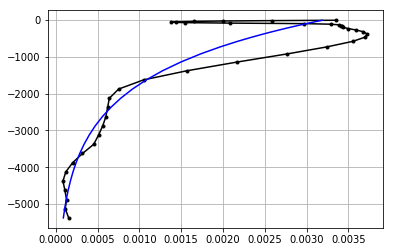

In [52]:
plt.plot(np.sqrt(N2_tmp),zz,'.-k',N0*np.exp(zz/b),zz,'b'); plt.grid(True)
N0*b, fNmoy(2000)*2000

In [42]:
# ------ prepare netcdf file and store "fix" variables---------------------------

ncw = Dataset(path_write+file_write,'w')

ncw.createDimension('z',zz.size)
ncw.createDimension('lon',nlon)
ncw.createDimension('lat',nlat)
ncw.createDimension('kh',nxout)
ncw.createDimension('theta',nxoth)
#ncw.createDimension('nmodes',nmodes)
ncw.createVariable('z','f',('z',))
ncw.createVariable('N2z','f',('z'))
ncw.createVariable('lon','f',('lat','lon'))
ncw.createVariable('lat','f',('lat','lon'))
ncw.createVariable('h','f',('lat','lon'))
ncw.createVariable('ue','f',('lat','lon'))
ncw.createVariable('ve','f',('lat','lon'))
var = ncw.createVariable('phi','f',('lat','lon'))
var.long_name = 'angle between ellipse major-axis and x-axis'
var.units = 'deg'
var = ncw.createVariable('lambda1','f',('lat','lon'))
var.long_name = 'equivalent mode 1 horizontal wavelength'
var.units = 'km'
ncw.createVariable('N2b','f',('lat','lon'))
ncw.createVariable('N0','f',()) # works even if N0 and b are constant 
ncw.createVariable('b','f',())
ncw.createVariable('f','f',('lat','lon'))
ncw.createVariable('kh','f',('kh'))
var.long_name = 'equivalent mode number'
var = ncw.createVariable('theta','f',('theta'))
var.longname = "wave-vector angle"
var.units = "rad"
var = ncw.createVariable('Ef','f',('lat','lon','kh','theta')) # case 1 
var.long_name = 'Energy flux (lat,lon,K,theta)'                 # case 1 
var = ncw.createVariable('Ef_a','f',('lat','lon','kh'))         # case 2 
var.long_name = 'Azimuthally-averaged energy flux (lat,lon,K)'   # case 2 
var = ncw.createVariable('Ef_t','f',('lat','lon'))
var.long_name = 'Total energy flux (lat,lon)'
var = ncw.createVariable('h_sp','f',('lat','lon','kh','theta'))
var.long_name = 'Local spectrum of topography (lat,lon,K,theta)'
ncw.variables['z'][:]      = zz
ncw.variables['N2z'][:]    = N2_tmp
ncw.variables['lon'][:]    = lon2d.T
ncw.variables['lat'][:]    = lat2d.T
ncw.variables['h'][:]      = hgrid.T
ncw.variables['ue'][:]     = ue.T
ncw.variables['ve'][:]     = ve.T
ncw.variables['phi'][:]    = np.rad2deg(phi.T)
ncw.variables['N0'][:]     = N0
ncw.variables['b'][:]      = b
ncw.variables['f'][:]      = f.T
ncw.variables['kh'][:]     = khout
ncw.variables['theta'][:]  = thout 

ncvar = ncw.variables

In [43]:
# ====== BEGINNING OF REGIONAL LOOP ON LAT,LON ======================
tmes, tmeb = time.clock(), time.time()

for j in range(nlat): #
    clock_diff = datetime.now() - clock
    hour,sec = divmod(clock_diff.seconds,3600)
    hour     = hour + clock_diff.days*24
    minu,sec = divmod(sec,60)
    print( ' ---> proc %.3i, time spent : %.2i h %.2i min %.2i sec, computation is at %.1f percent'\
          %(rank,hour,minu,sec,float(j)/nlat*100.)) 
    for i in range(nlon): #
        xpos, ypos = lon2d[i,j], lat2d[i,j]
        ix, jy = np.unravel_index( ((lon_h-xpos)**2 + (lat_h-ypos)**2).argmin() , (nlon_h,nlat_h))
        xx = np.cumsum(dx_h[:,jy]) - dx_h[:ix+1,jy].sum()    # substracte midle point
        yy = np.cumsum(dy_h[ix,:]) - dy_h[ix,:jy+1].sum()
        #degy = Lchk/Erad*180./np.pi
        #degx = degy/np.cos(ypos*np.pi/180.)
        # endpoints
        #il = np.abs(lon_h[:,jy]-xpos+degx).argmin()-2
        #ir = np.abs(lon_h[:,jy]-xpos-degx).argmin()+2
        #jb = np.abs(lat_h[ix,:]-ypos+degy).argmin()-2
        #jt = np.abs(lat_h[ix,:]-ypos-degy).argmin()+2
        il = np.abs(xx+Lchk).argmin() - 2    # indices in global (topo) full-resolution grid
        ir = np.abs(xx-Lchk).argmin() + 2
        jb = np.abs(yy+Lchk).argmin() - 2
        jt = np.abs(yy-Lchk).argmin() + 2
        
        indx = slice(max(il,0),min(ir,nlon_h))
        indy = slice(max(jb,0),min(jt,nlat_h))
        h = h_t[indy,indx].T   
        lon = lon_h[indx,indy]
        lat = lat_h[indx,indy]
        xx, yy = xx[indx], yy[indy]
        # approximation: take mean cell size to compute wavenumbers
        dxi = 0.5*(dx_h[indy,indx].mean() + dy_h[indy,indx].mean())
        #dxi = 0.5*(np.diff(lon,axis=0).mean()*np.cos(ypos*np.pi/180.) \
        #            + np.diff(lat,axis=1).mean())*Erad*np.pi/180.
        
        # do we need to pad ?
        npadl = npadr = npadt = npadb = 0
        if -Lchk < xx.min():
            if il > 0: print('problem')
            npadl = int((xx.min() + Lchk)/dxi) + 1
        if xx.max() < Lchk:
            if ir < nlon_h: print('problem')
            npadr = int((Lchk - xx.max())/dxi) + 1
        if -Lchk < yy.min():
            if jb > 0: print('problem')
            npadb = int((yy.min() + Lchk)/dxi) + 1
        if yy.max() < Lchk:
            if jt < nlat_h: print('problem')
            npadt = int((Lchk - yy.max())/dxi) + 1

        if max(npadl,npadr,npadt,npadb) > 0:
            h = np.pad(h,((npadl,npadr),(npadb,npadt)),'edge')
        # make it square (again)
        dn = h.shape[1] - h.shape[0]
        if dn < 0:
            h = h[(-dn)//2:-((-dn)//2+(-dn)%2),:]
        elif dn > 0:
            h = h[:,dn//2:-(dn//2+dn%2)]
        if np.abs(dn) > 3: print('squaring {0} at i={1}, j={2}'.format(np.abs(dn),i,j))
        nx, ny = h.shape
        if nx != ny: print('problem still not square')
            
        kx = np.fft.fftshift(np.fft.fftfreq(nx,dxi))*2*np.pi # wavenumbers in x-direction = major axis
        dk = kx[1]-kx[0]
        h = detrend_2d(h) # apply bilinear detrend
        win_x   = np.tile(np.hanning(nx),(1,1))  # window before fft-ing 
        win     = np.dot(win_x.T,win_x)
        int_rec = nx**2             # integral of a squared rectangular window (as if no windowing) 
        int_win = np.nansum(win**2) # integral of the squared window 
        norm    = (int_rec/int_win)*1/(nx**2*dk**2) # [1/(rad m-1)^2] normalization constant 
        sp = norm*abs(np.fft.fftshift(np.fft.fft2(h*win)))**2
        sp = sp*np.nanvar(h)/np.sum(sp*dk*dk)
        kx2d,ky2d = np.meshgrid(kx,kx)
        sp[np.where(np.logical_and(kx2d==0,ky2d==0))] = np.nan # remove continuous component
        
        sp_polar, r, theta = reproject_image_into_polar(sp.T,origin=(nx//2,nx//2),theta_shift=(phi[i,j]+angrid[i,j]))
        kh = r*dk # r is in pixel, multiply by dk to get wavenumber
        sp_polar[r==0]=np.nan

            
        weight = ( ue[i,j]**2*np.cos(theta)**2 + ve[i,j]**2*np.sin(theta)**2 )
        gamma = sp_polar*weight[None,:]*kh[:,None]
            
        N2b = fN2(hgrid[i,j])
        
        # --- compute Ef(K,theta) ---
        coef = 0.5*rho0*((N2b-M2**2)*(M2**2-f[i,j]**2))**0.5/M2 
        Ef = coef*gamma 

        # --- azimuthal integration [0,2pi] ---
        dtheta = theta[1] - theta[0] 
        Ef_a = np.nansum(Ef*dtheta,axis=1)*kh/(2*np.pi)

        # --- equivalent mode number Eq (6) in StL and G 2002 ---  
        #k1 = np.pi*(M2**2-f[i,j]**2)**0.5/(b*N0) # Eq (6), H neglected
        k1 = np.pi*np.sqrt(M2**2-f[i,j])/(b*N0*(1-np.exp(hgrid[i,j]/b)))
        dkj = k1 
        
        try:   
            kmin_int = np.nanargmin(abs(kh-(k1-0.5*dkj)))+1 # min index over which performing integral
        except: # land points
            kmin_int = -1
        
        # store in netCDF file NRJ fluxes
        ncvar['Ef'][j,i,:,:] = interp.RectBivariateSpline(kh,theta,Ef,kx=1,ky=1)(khout,thout)  # energy flux sp. density
        ncvar['Ef_a'][j,i,:] = interp.pchip(kh,Ef_a)(khout)     # NRJ flux azimuth.-averaged
        ncvar['Ef_t'][j,i] = np.nansum(Ef_a[kmin_int:]*dk) # total NRJ flux
        ncvar['h_sp'][j,i,:,:] = interp.RectBivariateSpline(kh,theta,sp_polar,kx=1,ky=1)(khout,thout) # spectrum of topography
        ncvar['N2b'][j,i]    = N2b
        ncvar['lambda1'][j,i] = 2*np.pi/k1/1e3
# ------ end of loop: print timing ---------------------------
        print(time.clock()-tmes,time.time()-tmeb)
        tmes,tmeb = time.clock(), time.time()
ncw.close()

clock_diff = datetime.now() - clock
hour,sec = divmod(clock_diff.seconds,3600)
hour     = hour + clock_diff.days*24
minu,sec = divmod(sec,60)
print(' ===> proc %.3i, time spent : %.2i h %.2i min %.2i sec, save in netcdf file '\
      %(rank,hour,minu,sec)) 
print(time.clock()-tmes,time.time()-tmeb)

 ---> proc 000, time spent : 00 h 03 min 05 sec, computation is at 0.0 percent
0.7243759999999995 0.39319396018981934
0.6786279999999998 0.1460566520690918
0.6543670000000006 0.14220714569091797
0.6892500000000013 0.1410820484161377
0.6338919999999995 0.14450931549072266
0.6932050000000025 0.14012622833251953
0.6528740000000006 0.14207935333251953
0.6930189999999996 0.13959956169128418
0.6495809999999977 0.14210915565490723
0.692971 0.1391913890838623
0.6391249999999999 0.1414806842803955
0.6893710000000013 0.13988351821899414
0.678763 0.17551898956298828
 ---> proc 000, time spent : 00 h 03 min 07 sec, computation is at 7.7 percent
0.69388 0.14001107215881348
0.6486239999999981 0.14121079444885254
0.6933119999999988 0.13980960845947266
0.6586799999999968 0.14540743827819824
0.6943940000000026 0.14136981964111328
0.6542300000000054 0.14053034782409668
0.6939160000000015 0.1401047706604004
0.6501720000000049 0.14205527305603027
0.6283649999999952 0.1576230525970459
0.5929799999999972 0.

In [62]:
rot_uv(0,1,-np.pi/2)

(1.0, 6.123233995736766e-17)